In [6]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [7]:
from cinplaAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [8]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [9]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [10]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False,plotCB=False,xlabels=False,title=None):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))

    rms = np.mean(np.sqrt(csd**2))
    
    im = ax.imshow(np.array(csd)/rms, origin='lower',cmap='bwr_r',vmin=-10,vmax=10)#, vmin =-absmax,vmax=absmax, cmap='bwr_r')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])

    if xlabels:
        ax.set_xticks([2000,2050],labels=['0','50'])
        # ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([50,100])
    else:
        ax.set_xlim([2000,2050])

    if title:
        plt.title(title)

    plt.tight_layout()

In [8]:
highRes = np.load('highRes/total.npy') # Loads LFP and oCSD averaged over trials, 20 um spacing, rho=500um

lfpIdx = np.arange(101) 

totalLFPHighRes = highRes[:,lfpIdx] # LFP, 20 um spacing
totalLFPLowRes = totalLFPHighRes[:,0:totalLFPHighRes.shape[1]:2] # LFP, 40 um spacing
totalLFPLowResHalf = totalLFPHighRes[:,0:totalLFPHighRes.shape[1]:4] # LFP, 80 um spacing
totalLFPLowResQuarter = totalLFPHighRes[:,0:totalLFPHighRes.shape[1]:8] # LFP, 160 um spacing

disk_fullDensity_idx = np.arange(202,303)
objective_disk_full_highRes = highRes[:,disk_fullDensity_idx] # oCSD, 20 um spacing



In [ ]:
### Calculates oCSD for 40, 80, and 160 um electrode spacing, with rho of 500 um, by taking the sum of neighboring electrodes in the 20 um case

objective_disk_full_lowRes = np.zeros_like(totalLFPLowRes)
objective_disk_half_lowRes = np.zeros_like(totalLFPLowResHalf)
objective_disk_quarter_lowRes = np.zeros_like(totalLFPLowResQuarter)

for l in range(objective_disk_full_lowRes.shape[1]):
    if l == 0:
        objective_disk_full_lowRes[:,l] = objective_disk_full_highRes[:,2*l]+.5*objective_disk_full_highRes[:,2*l+1]
    elif l == objective_disk_full_lowRes.shape[1]-1:
        objective_disk_full_lowRes[:,l] = objective_disk_full_highRes[:,2*l]+.5*objective_disk_full_highRes[:,2*l-1]
    else:
        objective_disk_full_lowRes[:,l] = objective_disk_full_highRes[:,2*l]+.5*objective_disk_full_highRes[:,2*l-1]+.5*objective_disk_full_highRes[:,2*l+1]

for l in range(objective_disk_half_lowRes.shape[1]):
    if l == 0:
        objective_disk_half_lowRes[:,l] = objective_disk_full_lowRes[:,2*l]+.5*objective_disk_full_lowRes[:,2*l+1]
    elif l == objective_disk_half_lowRes.shape[1]-1:
        objective_disk_half_lowRes[:,l] = objective_disk_full_lowRes[:,2*l]+.5*objective_disk_full_lowRes[:,2*l-1]
    else:
        objective_disk_half_lowRes[:,l] = objective_disk_full_lowRes[:,2*l]+.5*objective_disk_full_lowRes[:,2*l-1]+.5*objective_disk_full_lowRes[:,2*l+1]

for l in range(objective_disk_quarter_lowRes.shape[1]):
    if l == 0:
        objective_disk_quarter_lowRes[:,l] = objective_disk_half_lowRes[:,2*l]+.5*objective_disk_half_lowRes[:,2*l+1]
    elif l == objective_disk_quarter_lowRes.shape[1]-1:
        objective_disk_quarter_lowRes[:,l] = objective_disk_half_lowRes[:,2*l]+.5*objective_disk_half_lowRes[:,2*l-1]
    else:
        objective_disk_quarter_lowRes[:,l] = objective_disk_half_lowRes[:,2*l]+.5*objective_disk_half_lowRes[:,2*l-1]+.5*objective_disk_half_lowRes[:,2*l+1]


In [9]:
### Calculates iCSD and standard CSD

diam = 1000E-6 * pq.m                              # [m]
sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

step_input_high = {
    'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
    'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':20E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

step_input_low = {
    'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':40E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

step_input_low_half = {
    'lfp' : totalLFPLowResHalf.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 80 * np.arange(0,totalLFPLowResHalf.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':80E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

step_input_low_quarter = {
    'lfp' : totalLFPLowResQuarter.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 160 * np.arange(0,totalLFPLowResQuarter.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':160E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

std_input_high = {
    'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
    'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low = {
    'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low_half = {
    'lfp' : totalLFPLowResHalf.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 80 * np.arange(0,totalLFPLowResHalf.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low_quarter = {
    'lfp' : totalLFPLowResQuarter.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 160 * np.arange(0,totalLFPLowResQuarter.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}


icsd_high = StepiCSD(**step_input_high)
icsd_low = StepiCSD(**step_input_low)
icsd_low_half = StepiCSD(**step_input_low_half)
icsd_low_quarter = StepiCSD(**step_input_low_quarter)

icsd_high_std = StandardCSD(**std_input_high)
icsd_low_std = StandardCSD(**std_input_low)
icsd_low_half_std = StandardCSD(**std_input_low_half)
icsd_low_quarter_std = StandardCSD(**std_input_low_quarter)
        

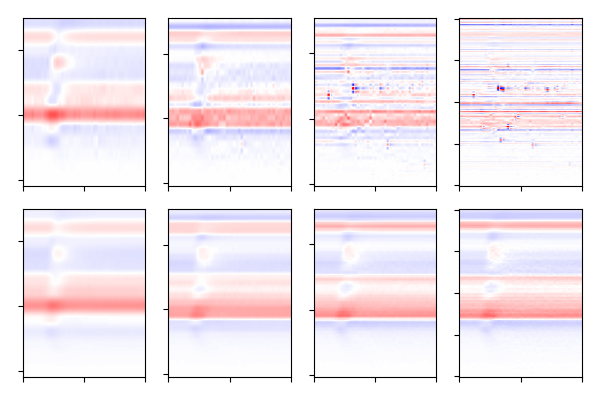

In [20]:
### Plots Figure 2a

fig, axes = plt.subplots(2,4,figsize=(6,4))

plotFig(axes[0][0],icsd_low_quarter.get_csd())
plotFig(axes[1][0],objective_disk_quarter_lowRes.T)

plotFig(axes[0][1],icsd_low_half.get_csd())
plotFig(axes[1][1],objective_disk_half_lowRes.T)

plotFig(axes[0][2],icsd_low.get_csd())
plotFig(axes[1][2],objective_disk_full_lowRes.T)

plotFig(axes[0][3],icsd_high.get_csd())
plotFig(axes[1][3],objective_disk_full_highRes.T)

plt.savefig('figures/csds.png',dpi=600)


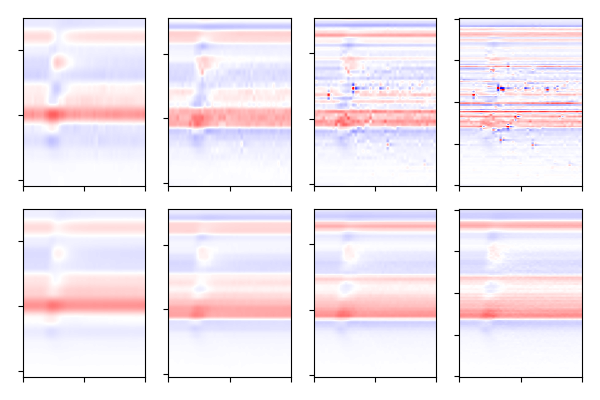

In [10]:
### Plots the equivalent of Figure 2a, but for standard CSD instead of iCSD. Not used in the paper

fig, axes = plt.subplots(2,4,figsize=(6,4))

plotFig(axes[0][0],icsd_low_quarter_std.get_csd())
plotFig(axes[1][0],objective_disk_quarter_lowRes.T)

plotFig(axes[0][1],icsd_low_half_std.get_csd())
plotFig(axes[1][1],objective_disk_half_lowRes.T)

plotFig(axes[0][2],icsd_low_std.get_csd())
plotFig(axes[1][2],objective_disk_full_lowRes.T)

plotFig(axes[0][3],icsd_high_std.get_csd())
plotFig(axes[1][3],objective_disk_full_highRes.T)

plt.savefig('figures/csds_std.png',dpi=600)

In [25]:
### Calculates correlations between iCSD and oCSD for all electrode spacings

correlations_high_stim = []
correlations_low_stim = []
correlations_low_half_stim = []
correlations_low_quarter_stim = []

for i in np.arange(2000,2050):
    correlations_high_stim.append(np.corrcoef(icsd_high.get_csd()[:,i],objective_disk_full_highRes.T[:,i])[0,1])
    correlations_low_stim.append(np.corrcoef(icsd_low.get_csd()[:,i],objective_disk_full_lowRes.T[:,i])[0,1])
    correlations_low_half_stim.append(np.corrcoef(icsd_low_half.get_csd()[:,i],objective_disk_half_lowRes.T[:,i])[0,1])
    correlations_low_quarter_stim.append(np.corrcoef(icsd_low_quarter.get_csd()[:,i],objective_disk_quarter_lowRes.T[:,i])[0,1])


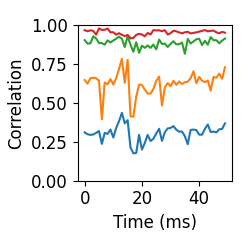

In [27]:
### Plots Figure 2b

plt.figure(figsize=(2.5,2.5))
plt.plot(correlations_high_stim,c='C0')
plt.plot(correlations_low_stim,c='C1')
plt.plot(correlations_low_half_stim,c='C2')
plt.plot(correlations_low_quarter_stim,c='C3')

plt.ylim([0,1])
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('figures/correlations.png',dpi=300)

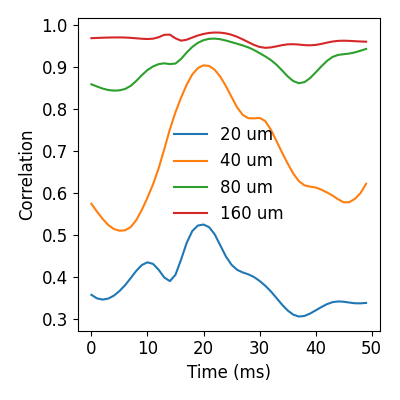

In [25]:
### Plots Figure 2b again, but with a legend

plt.figure(figsize=(4,4))
plt.plot(correlations_high_stim,c='C0',linestyle=None)
plt.plot(correlations_low_stim,c='C1',linestyle=None)
plt.plot(correlations_low_half_stim,c='C2',linestyle=None)
plt.plot(correlations_low_quarter_stim,c='C3',linestyle=None)

# plt.plot(correlations_high_rest,'--',c='C0')
# plt.plot(correlations_low_rest,'--',c='C1')
# plt.plot(correlations_low_half_rest,'--',c='C2')
# plt.plot(correlations_low_quarter_rest,'--',c='C3')

plt.legend(['20 um', '40 um','80 um','160 um'],framealpha=0)
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('figures/correlations_legend.png',dpi=300)